# Random Forest (Classification)

This notebook implements the custom random forest algorithm for classification on the Palmer Penguins dataset. Here, a random forest classifier is used to classify penguins by sex based on input data for various numerical features, including bill length, bill width, flipper length, and body mass. The objective of this task is to validate the use of the custom random forest class, and evaluate its performance for a binary multi-feature classification problem.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Palmer Penguins dataset with relevant features
- Drops outliers, duplicates, and missing data
- Creates arrays for the features and target variable
3. **Data Visualization**
- Visualizes the correlation between features using a heatmap
- Visualizes the distribution of two features with the target on a 2D color plot
4. **Random Forest Implementation (2 Features)**
- Implements the custom-built random forest algorithm with two input features  
- Visualizes the classification  
- Evaluates the results across multiple metrics  
5. **Random Forest Implementation (Changing Parameters)**
- Implements the custom-built random forest algorithm with various parameters (number of trees, maximum depth, minimum samples to split)
- Examines the effect on model performance
6. **Random Forest Implementation (Multiple Features)**
- Implements the custom-built random forest algorithm with more than two features to ensure functionality
- Evaluates the results across multiple metrics
- Compares the effects of changing the maximum feature parameter
7. **Comparison with Existing Models**
- Runs the scikit-learn version of random forest
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the random forest algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run the random forest algorithm. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Seaborn 0.13.2

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.randomforest import *
from rice_ml.postprocess.classificationpost import *

### Data Loading & Cleaning
*Loading, preprocessing, and dividing data*

The data used in this notebook comes from Palmer Penguins, a common toy dataset for evaluating classification algorithms. It has been selected for its simplicity and clear feature relationships, and because it requires several data cleaning steps that showcase the `rice_ml` preprocessing modules, including handling missing values. The features of interest in this example are *sex* (categorical and the target variable for classification), *bill length* (numeric), *bill depth* (numeric), *flipper length* (numeric), and *body mass* (numeric). 

The data is first loaded as a Pandas DataFrame. For classification, the *sex* feature is converted into discrete integer values from 0 to 1, each representing a separate sex (male or female).

In [260]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "sex", 
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]

# Encoding the target as a numeric feature
penguin_features.loc[:, 'sex'], uniques = pd.factorize(penguin_features['sex'])
display(penguin_features)

,sex,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,1,39.5,17.4,186.0,3800.0
2,1,40.3,18.0,195.0,3250.0
3,-1,NaN,NaN,NaN,NaN
4,1,36.7,19.3,193.0,3450.0
...,...,...,...,...,...
339,-1,NaN,NaN,NaN,NaN
340,1,46.8,14.3,215.0,4850.0
341,0,50.4,15.7,222.0,5750.0
342,1,45.2,14.8,212.0,5200.0


The dataset contains some missing or NaN values (e.g., row 4) and may contain outlier or duplicate rows that will skew the results of the classification. To clean the data, we apply a series of preprocessing steps from the `rice_ml` preprocessing package, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another. Moreover, we drop any rows with an instance of -1 in the column denoting sex, as this indicates an originally NaN value.

In [261]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
penguin_features_cleaned = penguin_features_cleaned[~np.any(penguin_features_cleaned < 0, axis=1)]
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[0.00e+00 3.91e+01 1.87e+01 1.81e+02 3.75e+03]
 [1.00e+00 3.95e+01 1.74e+01 1.86e+02 3.80e+03]
 [1.00e+00 4.03e+01 1.80e+01 1.95e+02 3.25e+03]
 [1.00e+00 3.67e+01 1.93e+01 1.93e+02 3.45e+03]
 [0.00e+00 3.93e+01 2.06e+01 1.90e+02 3.65e+03]]


Multiple rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in random forest and for ease of visualization, the dataset must be split into the target (*sex*) and the remaining features.

In [262]:
# Creating two arrays
penguin_sex = penguin_features_cleaned[:, 0]
penguin_feature_data = penguin_features_cleaned[:, 1:]
print(f"Array for sex (first five entries): \n {penguin_sex[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for sex (first five entries): 
 [0. 1. 1. 1. 0.] 
 
 Array for penguin feature data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


### Data Visualization
*Correlations and feature plotting*

Once the data has been appropriately cleaned, the relationships between variables can be visualized using a set of methods. We first visualize the correlations between features using a heatmap of a calculated correlation matrix, applied to the cleaned DataFrame that includes all relevant features. Doing so allows for the identification of features that are correlated with the target, and may thus be appropriate for classification using random forest.

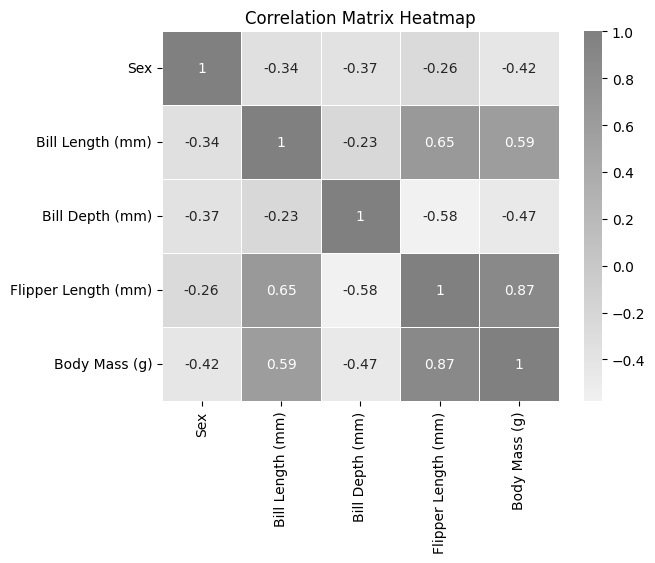

In [263]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Sex', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap = sns.light_palette('gray', as_cmap=True), linewidths = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Both bill depth and body mass appear to be correlated with sex (-0.34 and -0.42, respectively). Consequently, these features are appropriate for a two-variable random forest algorithm, and we will select them as the features for predicting sex. To visualize the relationship between the three variables (*bill length*, *bill depth*, and *sex*) and identify possible trends prior to formal analysis, we can create a two-dimensional plot of body mass versus bill depth, with colors indicating sex.

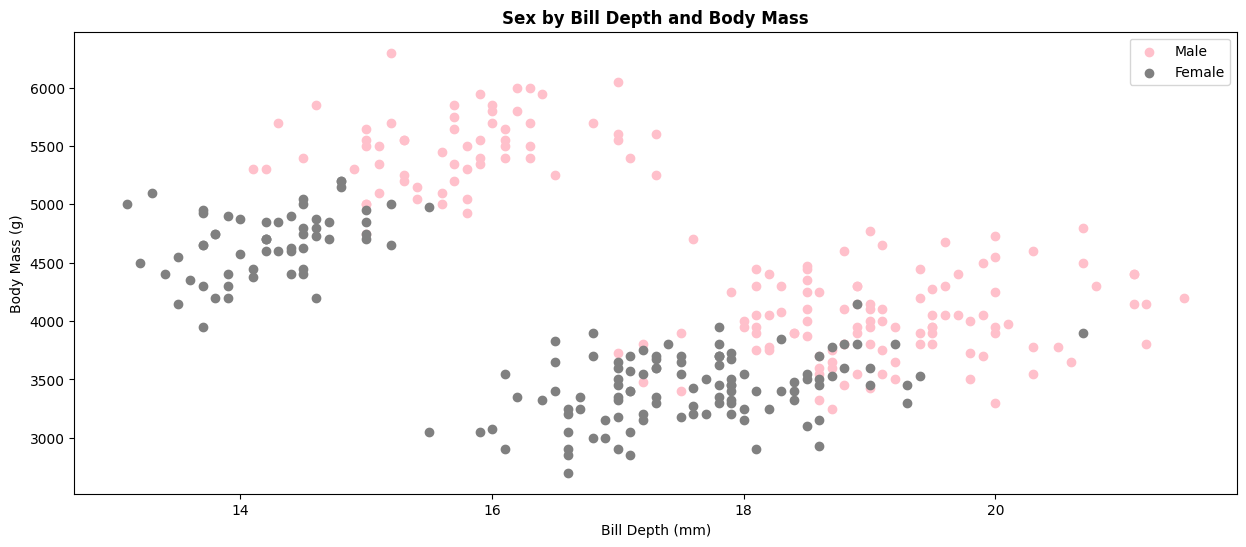

In [264]:
# Plotting bill depth and body mass, color-coded by sex
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}

plt.figure(figsize = (15, 6))
for sex in np.unique(penguin_sex):
    mask = (penguin_sex == sex)
    plt.scatter(penguin_feature_data[mask, 1], penguin_feature_data[mask, 3], label = sex, color = colors[sex])
    
plt.legend(['Male', 'Female'])
plt.title("Sex by Bill Depth and Body Mass", fontweight = 'bold')
plt.xlabel("Bill Depth (mm)")
plt.ylabel("Body Mass (g)")

plt.show()

The plot demonstrates that bill depth and body mass form two separate clusters, each of which has a clear distribution of the male and female feature. Within a cluster, males tend to have larger body mass and bill depth, while females have a smaller body mass and bill depth. The distribution of this data suggests that it is an interesting candidate for assessing the custom random forest model.

### Random Forest Implementation (2 Features)
*Classification using random forest with two features*

This section implements the custom random forest class to classify sex based on body mass and bill depth. It carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the random forest model, we normalize the feature data using z-scores for each feature, calculated using the `preprocessing` package. This reduces the possibility that the relative scale of the feature will impact model results, and is standard practice in supervised learning. Feature normalization rescales each feature to prevent skewing results based on feature magnitude, ensuring that no one feature will overly contribute to model predictions.

In [265]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [1, 3]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[ 0.7807321  -0.56847478]
 [ 0.11958397 -0.50628618]
 [ 0.42472926 -1.1903608 ]
 [ 1.0858774  -0.94160639]
 [ 1.74702554 -0.69285199]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. The data is split in a 70/30 proportion such that the training data is 70% of the total dataset, and the testing data 30%. There are 333 samples in the cleaned dataset, so the training array should have approximately 233 samples and the testing should have 100.

Because this is a classification problem where the classes may not be evenly represented within the data, stratification is used to split the testing and training sets. Stratification is a division method that first groups the data based on a given label, then randomly samples from each group to ensure that they are proportionally represented in both the testing and training data. This method prevents significant bias arising from disproportionate class counts by preserving relative distributions and ensuring that each class is represented in the training data. In this case, the stratification method is based on the target (*sex*), which should guarantee that samples from each sex are present in each set.

In [266]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, penguin_sex, stratify = penguin_sex, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (233, 2)
Shape of training targets: (233,)
Shape of testing array: (100, 2)
Shape of testing targets: (100,)


Next, we perform classification using random forests by creating an instance of the `random_forest` class from the supervised learning package, and fitting it on the training data. The previously unseen test data is then provided to the fitted model to predict the sex. 

This random forest classifier has the following specifications:
- **Number of Trees:** 100
- **Task:** Classification
- **Maximum Depth:** None
- **Minimum Samples to Split:** 2
- **Maximum Features:** Square Root
- **Random State:** None

In [267]:
# Fitting the model
forest = random_forest(100, 'classification')
forest.fit(train_array, train_targets)

# Predicting sex based on testing data
prediction = forest.prediction(test_array)

When the model has been successfully fitted and returns the sex predictions for the test data, we evaluate its performance using a variety of visualization and scoring methods. These include plotting the predictions, displaying the overall confusion matrix, and calculating accuracy, precision, recall, and F1 scores for each class. For a description of these metrics, see this [README](README.md).

The plot below is a visualization of the random forest accuracy on the test data. The leftmost subplot displays the overall distribution of body mass and bill depth, color-coded for sex; pale points are all data, and darker points indicate the gold-standard sex labels for the test dataset. The rightmost subplot displays the same data, but with points that have been incorrectly classified by the random forest in yellow.

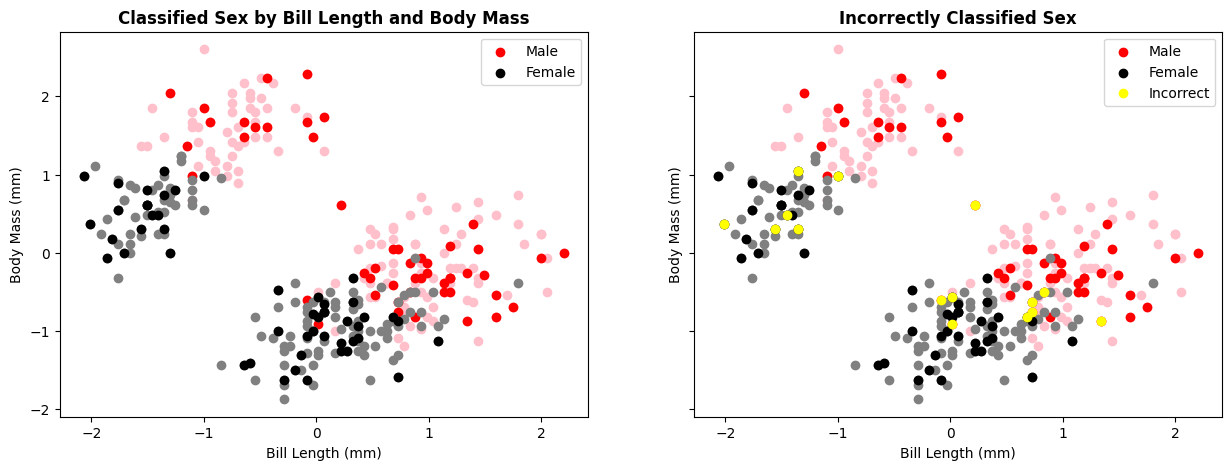

In [268]:
# Plotting bill depth and body mass, color-coded by sex
colors = {0: 'pink', 1: 'gray'}
colors_2 = {0: 'red', 1: 'black'}

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharex = True, sharey = True)

for sex in np.unique(penguin_sex):
    mask = (penguin_sex == sex)
    ax[0].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = sex, color = colors[sex])
    ax[1].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = sex, color = colors[sex])
    mask_new = (test_targets == sex)
    ax[0].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = sex, color = colors_2[sex])
    ax[1].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = sex, color = colors_2[sex])

mask_incorrect = (test_targets != prediction)
ax[1].scatter(test_array[mask_incorrect, 0], test_array[mask_incorrect, 1], label = 'Incorrect', color = 'yellow')

handles, labels = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in [1, 3]]
selected_handles_2 = [handles[i] for i in [1, 3, 4]]
ax[0].legend(handles = selected_handles, labels = ['Male', 'Female'])
ax[1].legend(handles = selected_handles_2, labels = ['Male', 'Female', 'Incorrect'])

ax[0].set_title("Classified Sex by Bill Length and Body Mass", fontweight = 'bold')
ax[1].set_title("Incorrectly Classified Sex", fontweight = 'bold')

for i in range(2):
    ax[i].set_xlabel("Bill Length (mm)")
    ax[i].set_ylabel("Body Mass (mm)")

plt.show()

The custom random forest has fair accuracy for sex classification, but labels multiple points incorrectly, especially those that occur in the overlap between the two classes or that are within the boundaries in each apparent cluster. For a more quantitative evaluation of the model, we plot the confusion matrix for each class, and produce the numerical evaluation metrics (accuracy, recall, precision, and F1 on the micro and macro scale).

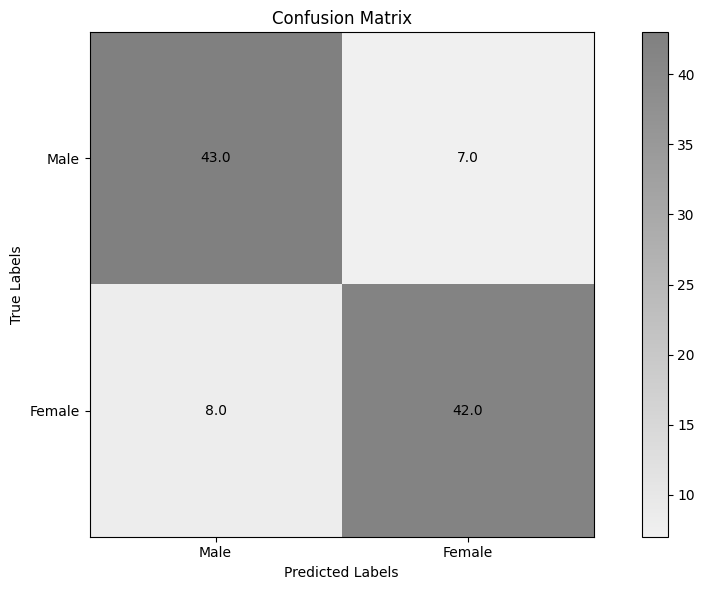

In [269]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction, test_targets, conf_matrix_labels = ['Male', 'Female'])

In [270]:
# Evaluating model performance on various metrics
print_model_metrics(prediction, test_targets)

Model Metrics 
------------- 
Accuracy: 0.85 
Precision (Micro): 0.85 
Precision (Macro): 0.85 
Recall (Micro): 0.85 
Recall (Macro): 0.85 
F1 (Micro): 0.85 
F1 (Macro): 0.85


This random forest classifier successfully classifies the sex of a test sample based on body mass and bill depth. The accuracy is above 80%, and the micro and macro scores for precision, recall, and F1 are all similarly high. The confusion matrix indicates several samples that have been misclassified, but in general, the predicted labels match the true labels. Overall, this validates the custom random forest classifier for a two-feature classification problem.

### Random Forest Implementation (Changing Parameters)
*Altering number of trees, maximum depth, and minimum samples to split*

This section implements the custom random forest classifier for classifying sex based on bill depth and body mass, but systematically changes a parameter in the model to determine the effects on performance. It first evaluates the model for different numbers of trees, using accuracy as the primary metric.

In [ ]:
# Arrays for number of trees and accuracy
tree_values = np.arange(1, 500, 50)
accuracy_values_trees = np.full(len(tree_values), np.nan)

# Fitting and scoring the model for each number of trees
for i in range(len(tree_values)):
    forest = random_forest(n_trees = int(tree_values[i]), task = 'classification')
    forest.fit(train_array, train_targets)
    prediction = forest.prediction(test_array)
    accuracy = accuracy_score(prediction, test_targets)
    accuracy_values_trees[i] = accuracy

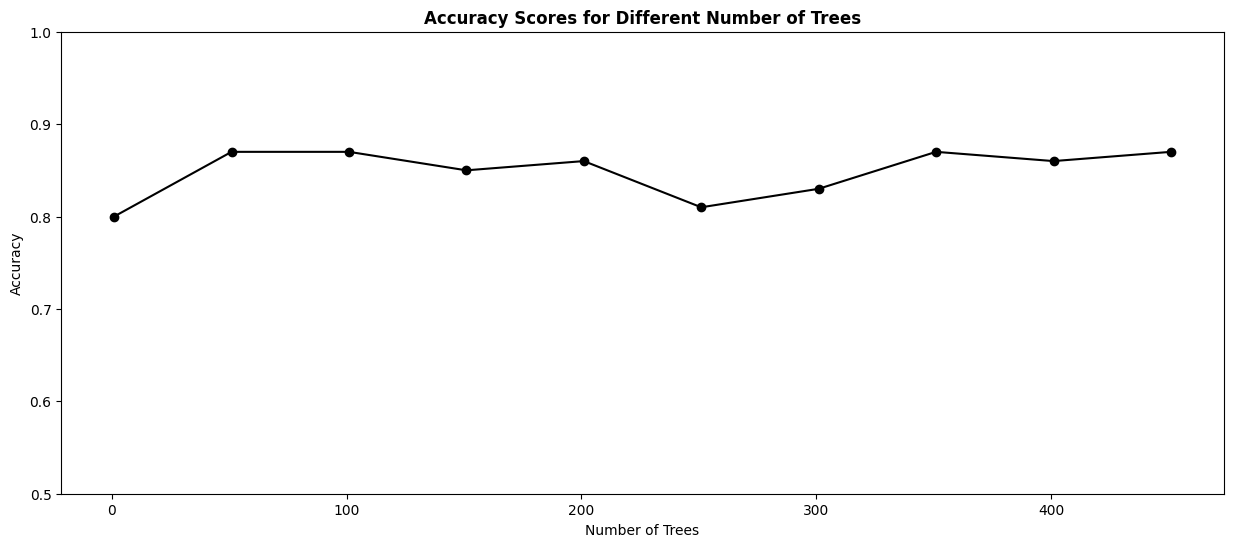

In [272]:
# Plotting the change in accuracy across different number of trees
plt.figure(figsize = (15, 6))
plt.plot(tree_values, accuracy_values_trees, 'black')
plt.scatter(tree_values, accuracy_values_trees, color = 'black')
plt.title("Accuracy Scores for Different Number of Trees", fontweight = 'bold')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1)
plt.show()

As the number of trees included in the random forest classifier increases, accuracy generally increases as well. At a very low number of trees (1 to 100), the accuracy varies, but stabilizes slighty as the tree count becomes higher. The accuracy does not necessarily plateau on every instance that the random forest classifier is run, which indicates that the number of trees continues to affect model accuracy at all tested points. However, for the remainder of the analysis, we use 500 for the number of trees to preserve computational efficiency while maintaining performance.

We now evaluate the model for different maximum depths, using accuracy as the primary metric.

In [273]:
# Arrays for maximum depth and accuracy
max_depth_values = np.arange(1, 11)
accuracy_values_max_depth = np.full(len(max_depth_values), np.nan)

# Fitting and scoring the model for each maximum depth
for i in range(len(max_depth_values)):
    forest = random_forest(n_trees = 500, task = 'classification', max_depth = int(max_depth_values[i]))
    forest.fit(train_array, train_targets)
    prediction = forest.prediction(test_array)
    accuracy = accuracy_score(prediction, test_targets)
    accuracy_values_max_depth[i] = accuracy

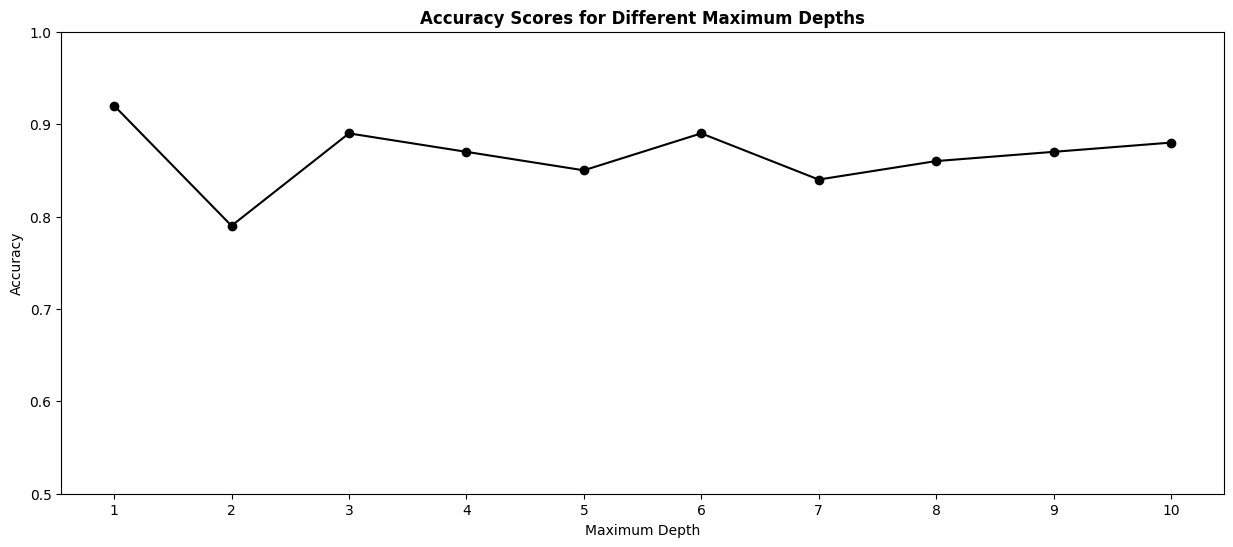

In [274]:
# Plotting the change in accuracy across different maximum depths
plt.figure(figsize = (15, 6))
plt.plot(max_depth_values, accuracy_values_max_depth, 'black')
plt.scatter(max_depth_values, accuracy_values_max_depth, color = 'black')
plt.title("Accuracy Scores for Different Maximum Depths", fontweight = 'bold')
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.ylim(0.5, 1)
plt.xticks(range(1, 11))
plt.show()

When the maximum depth of each tree in the random forest classifier is restricted to low values, the accuracy remains low as well. As the maximum depth increases, the accuracy generally increases, but begins to plateau at around 5 with little significant contribution to model performance beyond this. The exception to this trend is occasionally a maximum depth of 1, which produces a fairly accurate model. For the remainder of the analysis, we do not specify a particular depth at which the decision tree stops.

We now evaluate model performance with various values for the minimum samples required to split a node, with accuracy as the metric.

In [287]:
# Arrays for minimum samples to split
min_samples_values = np.arange(1, 11)
accuracy_values_min_samples = np.full(len(min_samples_values), np.nan)

# Fitting and scoring the model for each minimum sample
for i in range(len(min_samples_values)):
    forest = random_forest(n_trees = 500, task = 'classification', min_samples_split = int(min_samples_values[i]))
    forest.fit(train_array, train_targets)
    prediction = forest.prediction(test_array)
    accuracy = accuracy_score(prediction, test_targets)
    accuracy_values_min_samples[i] = accuracy

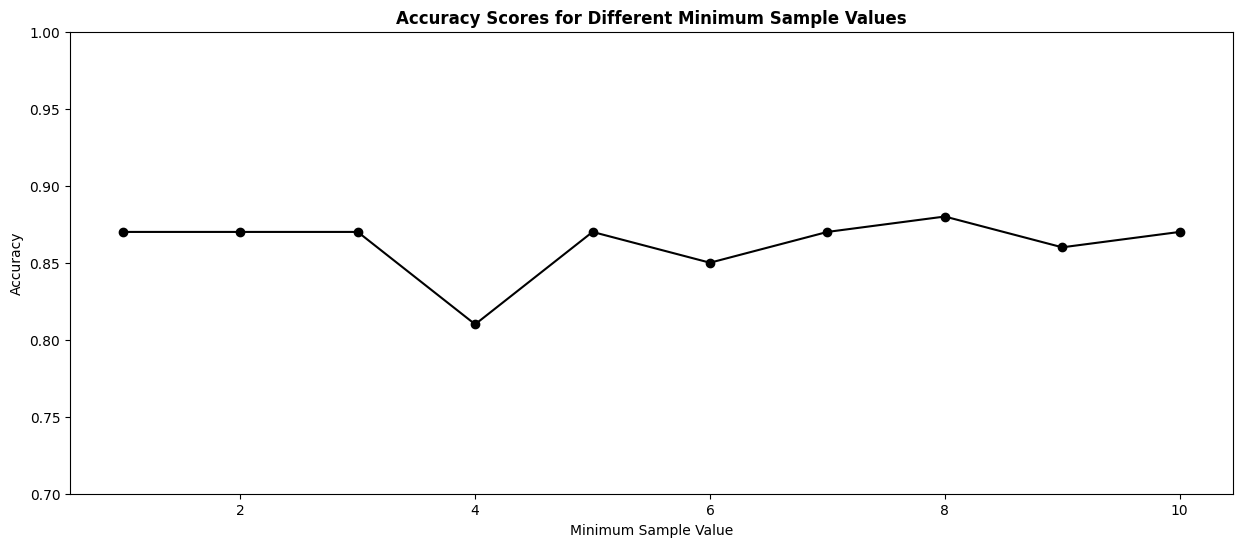

In [288]:
# Plotting the change in accuracy across different minimum split samples
plt.figure(figsize = (15, 6))
plt.plot(min_samples_values, accuracy_values_min_samples, 'black')
plt.scatter(min_samples_values, accuracy_values_min_samples, color = 'black')
plt.title("Accuracy Scores for Different Minimum Sample Values", fontweight = 'bold')
plt.xlabel("Minimum Sample Value")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.show()

The value set for the minimum samples needed to split impacts the accuracy of the random forest model, but not necessarily in a linear fashion. The accuracy is fairly high for a value of 1 to 3, but drops at around 4 to 5, then increases again as the value increases. However, the accuracy generally remains within a range of 0.80 to 0.90, which is acceptable for model performance. Therefore, we use the default minimum sample value of 2 for the remainder of the analysis.

### Random Forest Implementation (Multiple Features)
*Classification using random forest with multiple (four) features*

This section implements the custom random forest class to classify sex based on bill depth, bill length, flipper length, and body mass. As before, it carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the random forest model, we normalize the feature data using z-scores for each feature, again calculated using the `preprocessing` package. In this case, the entire feature data set (not simply the two selected features) is normalized and used in the random forest analysis. The data is then split into training (70%) and testing arrays (30%) with the stratification method based on sex label. Finally, a new instance of the random forest class is created and fit with the training data, then used to classify samples in the testing data.

This random forest classifier has the following specifications:
- **Number of Trees:** 500
- **Task:** Classification
- **Maximum Depth:** None
- **Minimum Samples to Split:** 2
- **Maximum Features:** Square Root
- **Random State:** None

In [289]:
# Standardizing the features
penguin_feature_data_mult = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_mult[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.89604189  0.7807321  -1.42675157 -0.56847478]
 [-0.82278787  0.11958397 -1.06947358 -0.50628618]
 [-0.67627982  0.42472926 -0.42637319 -1.1903608 ]
 [-1.33556603  1.0858774  -0.56928439 -0.94160639]
 [-0.85941488  1.74702554 -0.78365118 -0.69285199]]


In [290]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_mult, penguin_sex, stratify = penguin_sex, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (233, 4)
Shape of training targets: (233,)
Shape of testing array: (100, 4)
Shape of testing targets: (100,)


In [ ]:
# Fitting the model
forest_mult = random_forest(500, 'classification')
forest_mult.fit(train_array_mult, train_targets_mult)

# Predicting sex based on testing data
prediction_mult = forest_mult.prediction(test_array_mult)

Because the model takes in four features, there is no way to easily visualize the resulting classifications, as was possible with two features. Instead, model evaluation is done only using the confusion matrix and various performance metrics.

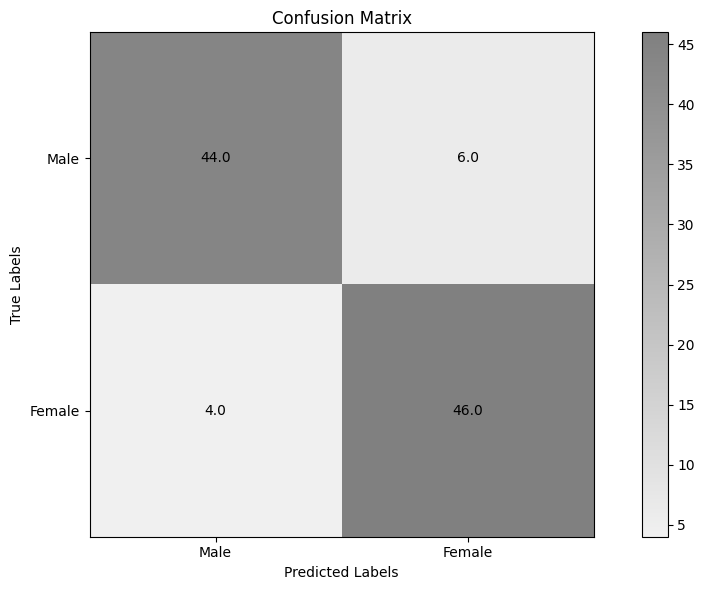

In [294]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction_mult, test_targets_mult, conf_matrix_labels = ['Male', 'Female'])

In [295]:
# Evaluating model performance on various metrics
print_model_metrics(prediction_mult, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 0.90 
Precision (Micro): 0.90 
Precision (Macro): 0.90 
Recall (Micro): 0.90 
Recall (Macro): 0.90 
F1 (Micro): 0.90 
F1 (Macro): 0.90


This model is much more accurate than the random forest classifier that only contained two features. It has a classification accuracy of up to 90%, with similar scores for precision, recall, and F1. The number of misclassified samples is low for each class, as shown in the confusion matrix. Consequently, the inclusion of additional features and the change in model metrics appears to benefit performance; this indicates the reliability and applicability of the custom-build random forest algorithm for multi-feature classification problems.

Finally, we assess the effect of changing the maximum number of features included in a decision tree by altering the applied metric. For computational efficiency, we use 100 trees rather than 500.

In [298]:
# Arrays for maximum number of features
max_features = [1, 2, 3, 4, 'sqrt', 'log2']
accuracy_values_max_features = np.full(len(max_features), np.nan)

# Fitting and scoring the model for each feature division
for i in range(len(max_features)):
    forest = random_forest(n_trees = 100, task = 'classification', max_features = max_features[i])
    forest.fit(train_array_mult, train_targets_mult)
    prediction_mult_test = forest.prediction(test_array_mult)
    accuracy = accuracy_score(prediction_mult_test, test_targets_mult)
    accuracy_values_max_features[i] = accuracy

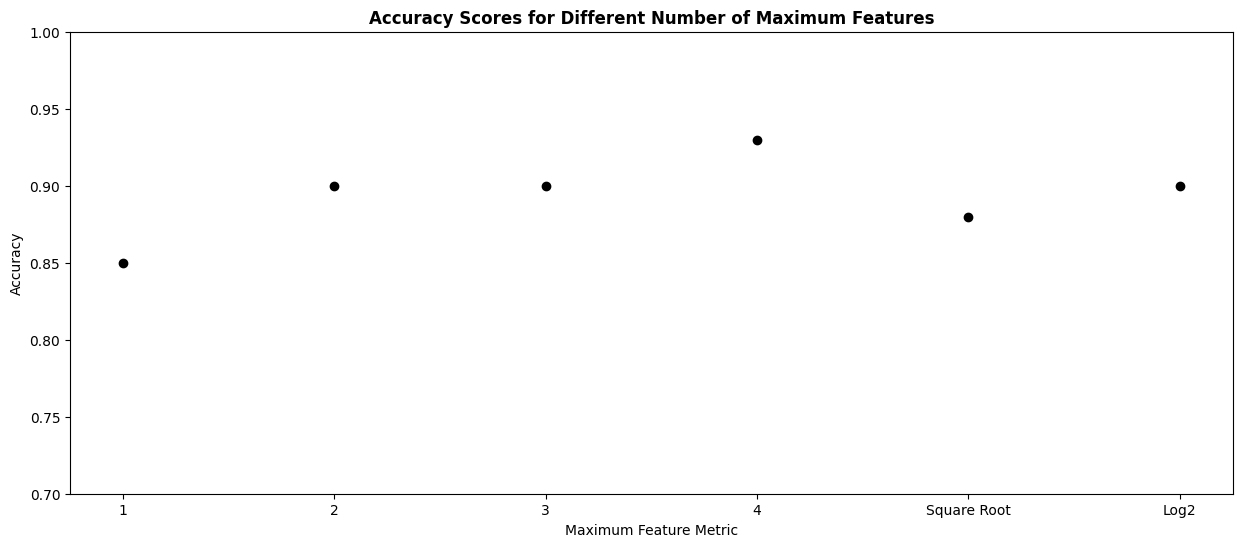

In [300]:
# Plotting the change in accuracy across different maximum features
plt.figure(figsize = (15, 6))
plt.scatter(['1', '2', '3', '4', 'Square Root', 'Log2'], accuracy_values_max_features, color = 'black')
plt.title("Accuracy Scores for Different Number of Maximum Features", fontweight = 'bold')
plt.xlabel("Maximum Feature Metric")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.show()

Changing the way in which the maximum features for a tree is determined has some effect on model accuracy. Using a low number of features (1) results in a lower classification accuracy, while increasing the number of features up to 4 generally increases accuracy. Using the square root and log2 metrics are successful as well, producing results that are similar to specifying 2 features manually.

### Comparison with Existing Models
*Comparison with scikit-learn random forest*

In order to ensure that the custom-built random forest algorithm is functioning as intended and providing expected results, it is useful to compare its performance to a random forest classifier from established code. In this section, we rerun the analysis with all four features using the scikit-learn random forest classifier with a matching number of trees (500), maximum depth (None), minimum samples to split (2), and maximum features (square root) to verify the results of the custom model.

In [ ]:
# Creating a random forest classifier using scikit-learn
from sklearn.ensemble import RandomForestClassifier
forest_sk = RandomForestClassifier(n_estimators = 500, max_depth = None, min_samples_split = 2, max_features = 'sqrt')
forest_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = forest_sk.predict(test_array_mult)

In [ ]:
# Printing the model metrics for the scikit-learn random forest
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 0.89 
Precision (Micro): 0.89 
Precision (Macro): 0.89 
Recall (Micro): 0.89 
Recall (Macro): 0.89 
F1 (Micro): 0.89 
F1 (Macro): 0.89


The scikit-learn random forest classifier has an accuracy score similar to that of the custom-build random forest model, as well as essentially equivalent precision, recall, and F1 scores. This suggests that the custom model is performing as expected on the given data, and does not indicate a malfunction or incorrect implementation. Therefore, the custom `rice_ml` random forest classifier is able to handle multi-feature classification problems to a professional standard.